# Analyse des données

## Utilisation
Dans ce notebook, on utilise `spylon` pour exécuter du code Scala.
Pour utiliser le notebook, il faut exécuter les commandes suivantes :
* Installer l'environnement virtuel Python :
  * On utilise Python 3.8.10 `pyenv shell 3.8.10`
  * On utilise Poetry pour la gestion de nos dépendances `poetry install`
* Installer le Kernel Scala :
  * `poetry shell`
  * `python -m spylon_kernel install --user`

Une fois que toutes ces étapes ont été faites, vous pouvez choisir le kernel `spylon-kernel` à l'exécution du notebook.

## Introduction 
Durant cette analyse, on va tenter de répondre à 4 questions que l'on se pose suite au traitement de la masse de données collectées par nos drones.

On va principalement manipuler les données avec Spark en Scala. On prendra la liberté d'utiliser Matplotlib en Python pour afficher des graphique comme le langage est plus adapté pour ce genre de manœuvre.

**Définition d'Alerte :** est une alerte pour un citoyen donné lorsque le PeaceScore dépasse le seuil de 50.

## Charger les données

In [1]:
val PEACESCORE_THRESHOLD = 50
val df = spark.read.csv("hdfs://localhost:9000/drone-reports")
    .withColumnRenamed("_c0","reportId")
    .withColumnRenamed("_c1","peaceWatcherId")
    .withColumnRenamed("_c2","time")
    .withColumnRenamed("_c3","latitude")
    .withColumnRenamed("_c4","longitude")
    .withColumnRenamed("_c5","heardWords")
    .withColumnRenamed("_c6","citizenId")
    .withColumnRenamed("_c7","peaceScores")

    .withColumn("reportId",col("reportId").cast("int"))
    .withColumn("peaceWatcherId",col("peaceWatcherId").cast("int"))
    .withColumn("time",to_timestamp(col("time"), "yyyy-MM-dd HH:mm:ss"))
    .withColumn("latitude",col("latitude").cast("double"))
    .withColumn("longitude",col("longitude").cast("double"))
    .withColumn("citizenId",col("citizenId").cast("int"))
    .withColumn("peaceScores",col("peaceScores").cast("int"))

    df.show()

Intitializing Scala interpreter ...

Spark Web UI available at http://192.168.1.33:4040
SparkContext available as 'sc' (version = 3.2.1, master = local[*], app id = local-1655059801192)
SparkSession available as 'spark'


+--------+--------------+-------------------+------------------+-----------------+----------+---------+-----------+
|reportId|peaceWatcherId|               time|          latitude|        longitude|heardWords|citizenId|peaceScores|
+--------+--------------+-------------------+------------------+-----------------+----------+---------+-----------+
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   345509|         27|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   757853|         32|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   235974|         17|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   539014|         46|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   694939|         58|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317

PEACESCORE_THRESHOLD: Int = 50
df: org.apache.spark.sql.DataFrame = [reportId: int, peaceWatcherId: int ... 6 more fields]


## Question 1 : Quels sont les jours de la semaine avec le nombre d'alertes le plus important ?

Cette question permet de savoir quand allouer plus de PeaceMakers durant la semaine et à contrario le moment parfait pour accorder un jour de congé à nos troupes de maintien de la paix.

In [2]:
import org.apache.spark.sql.functions._

val question_1_dataframe = df
    .dropDuplicates("reportId", "citizenId") // Retirer les doublons liés à la liste de mots heardWords
    .filter(col("peaceScores") > PEACESCORE_THRESHOLD)
    .withColumn("week_day", date_format(col("time"), "E")) // E pour day_of_week
    .groupBy("week_day")
    .count()
    .withColumnRenamed("count","Nombre d'alertes")

question_1_dataframe.show()
question_1_dataframe.createOrReplaceTempView("question_1_dataframe")

+--------+----------------+
|week_day|Nombre d'alertes|
+--------+----------------+
|     Sun|             239|
|     Mon|             223|
|     Thu|             178|
|     Sat|             194|
|     Wed|             224|
|     Fri|             213|
|     Tue|             194|
+--------+----------------+



import org.apache.spark.sql.functions._
question_1_dataframe: org.apache.spark.sql.DataFrame = [week_day: string, Nombre d'alertes: bigint]


          Nombre d'alertes
week_day                  
Thu                    178
Sat                    194
Tue                    194
Fri                    213
Mon                    223
Wed                    224
Sun                    239


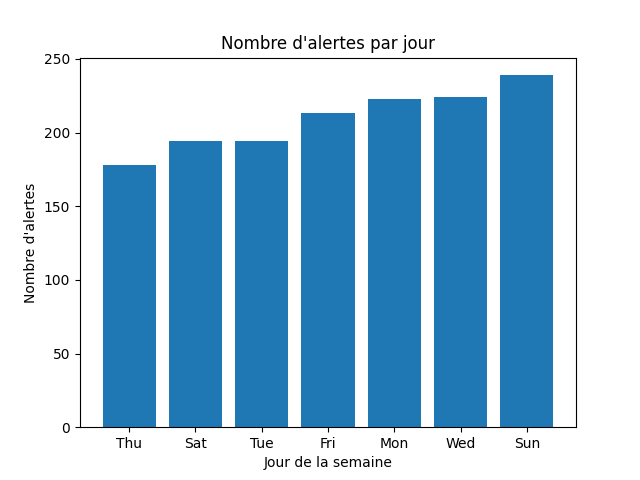

In [3]:
%%python
from matplotlib import pyplot as plt
from IPython.display import Image
import tempfile

df = spark.sql("select * from question_1_dataframe").toPandas()
df = df.set_index(df["week_day"]).drop("week_day", axis=1).sort_values("Nombre d'alertes")
print(df)
plt.bar(df.index, height=df["Nombre d'alertes"])
plt.title("Nombre d'alertes par jour")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre d'alertes")
with tempfile.NamedTemporaryFile(suffix=".png") as graph:
    plt.savefig(graph.name)
    retval = Image(filename=graph.name)

## Question 2 : Quelle est l'évolution de la moyenne des PeaceScores en fonction du mois de l'année ?

Ça nous permettra de connaître le moment dans l'année où la paix est la plus menacée et donc de savoir quel évenement ou quelle saison influence le plus l'humeur de nos citoyens. Dit autrement, on peut s'attendre à ce que les citoyens soient plus heureux en Été grâce au Soleil et moins en Hiver par manque de luminosité.

In [4]:
import org.apache.spark.sql.functions._

val question_2_dataframe = df
    .dropDuplicates("reportId", "citizenId")
    .withColumn("month", date_format(col("time"), "L")) // L pour month en texte
    .groupBy("month")
    .mean("peaceScores")
    .withColumnRenamed("avg(peaceScores)","peaceScores")

question_2_dataframe.show()
question_2_dataframe.createOrReplaceTempView("question_2_dataframe")

+-----+------------------+
|month|       peaceScores|
+-----+------------------+
|    3| 35.67884322678843|
|    5| 35.56191467221644|
|    6|  37.3142144638404|
|    1| 34.31147540983606|
|    4|35.265957446808514|
|    2| 36.44444444444444|
+-----+------------------+



import org.apache.spark.sql.functions._
question_2_dataframe: org.apache.spark.sql.DataFrame = [month: string, peaceScores: double]


## Question 3 : Quel est le moment de la journée où le nombre d'alertes est le plus important ?

Le nombre d'alertes en fonction du moment de la journée (0h à 23h) nous permet de savoir quand est-ce que l'on doit mettre plus de moyens pour maintenant la paix.

## Question 4 : Dans quelle zone de PeaceLand trouve-t-on le plus souvent des alertes ?

On considère ici que PeaceLand est une zone carrée composée de 4 arrondissements. On cherche à savoir quel arrondissement représente le plus une menace pour la paix de notre communauté.

## Question 5 : Quel est le mot associé avec le PeaceScore le plus élevé ?

On pourra alors prendre des mesures comme le bannissement définitif de ce mot du dictionnaire ! La Paix est plus importe que le vocabulaire !